# Part 2: Multi-tissue characterization of eSTRs

In [13]:
# Set up
%pylab inline

# Params
DATADIR = "/storage/mgymrek/gtex-estrs/revision/"
RESULTSDIR = "/storage/mgymrek/gtex-estrs/revision/figures"

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Import libraries
import os
import pandas as pd
import scipy.stats
import seaborn as sns
import statsmodels.stats.multitest

############ Set up paths #############
SAVEPLOT = True
MIN_CAUSAL_SCORE = 0.3 # Top 5%
GENEANNOT = "/storage/resources/dbase/human/hg19/gencode_gene_annotations_hg19.csv"

# Load mashR results
betas = pd.read_csv(os.path.join(DATADIR, "mashr", "output-strs", "posterior_betas.tsv"), sep="\t", index_col=0)
beta_ses = pd.read_csv(os.path.join(DATADIR, "mashr", "output-strs", "posterior_beta_ses.tsv"), sep="\t", index_col=0)
zscores = pd.read_csv(os.path.join(DATADIR, "mashr", "output-strs", "zscores.tsv"), sep="\t", index_col=0)
ntissues = len(betas.columns)

# Load eSTRs
estrs = pd.read_csv(os.path.join(RESULTSDIR, "SuppTable_CAVIAR.tsv"), sep="\t")
geneannot = pd.read_csv(GENEANNOT)
geneannot["gene"] = geneannot["gene.id"].apply(lambda x: x.split(".")[0])
estrs = pd.merge(estrs, geneannot[["gene", "gene.strand","gene.start","gene.stop"]], on=["gene"])
estrs["motif"] = estrs.apply(lambda x: x["str.motif.forward"] if x["gene.strand"]=="+" else x["str.motif.reverse"], 1)
estrs["dist.tss"] = estrs.apply(lambda x: (x["str.start"]-x["gene.start"]) if x["gene.strand"]=="+" else (x["gene.stop"]-x["str.start"]), 1)

causal = estrs[estrs["score"]>=MIN_CAUSAL_SCORE]

ZTHRESH = 3

Populating the interactive namespace from numpy and matplotlib


In [6]:
# Load master tables
COLORS = {
    "Artery-Aorta":"salmon",
    "Artery-Tibial": "red",
    "Adipose-Subcutaneous": "darkorange",    
    "Adipose-Visceral":"orange",
    "Brain-Caudate":"lemonchiffon"   , 
    "Brain-Cerebellum":"yellow",
    "Cells-Transformedfibroblasts": "skyblue",
    "Esophagus-Mucosa": "sienna",
    "Esophagus-Muscularis":"burlywood",
    "Heart-LeftVentricle":"darkviolet",
    "Lung": "greenyellow",
    "Muscle-Skeletal": "mediumslateblue",
    "Nerve-Tibial":"gold",
    "Skin-NotSunExposed":"blue",
    "Skin-SunExposed":"cornflowerblue",
    "Thyroid":"green",
    "WholeBlood": "m",
}
TISSUES = list(COLORS.keys())

# Master tables
master = {} # Map of tissue -> data
for t in TISSUES:
    d = pd.read_csv(os.path.join(DATADIR, "mastertables", "%s_master.tab"%t), sep="\t", 
                            usecols=["chrom","gene","gene.name","str.start","linreg.beta","linreg.pval", 
                                     "linreg.significant",
                                     "anova.pval","caviar.str.score","caviar.str.rank","mashr.significant"])
    d["gene"] = d["gene"].apply(lambda x: x.split(".")[0])
    d["signif_%s"%t] = d["linreg.significant"]
    master[t] =  d 

In [14]:
CAUSAL_COLOR = "black"
ESTR_COLOR = "gray"

def NormTable(t, total):
    x = t[0][0]+t[0][1]+t[1][0]
    t[1][1] = total-x
    return t

def GetEnrichments(ref, estrs, causal, annotations, annot_col=True):
    """
    Return data frame with estr and causal enrichments for all annotations
    if annot_col, use "annot" column. else use annotation os the column itself
    """
    num_total = []
    num_estrs = []
    pval_estrs = []
    odds_estrs = []
    num_causal = []
    pval_causal = []
    odds_causal = []
    
    dir_estrs = []
    pval_dir_estrs = []
    dir_causal = []
    pval_dir_causal = []
    
    estrs_annot = estrs.groupby(["chrom","str.start"], as_index=False).agg({"beta": maxabs})
    causal_annot = causal.groupby(["chrom","str.start"], as_index=False).agg({"beta": maxabs})

    estrs_annot = pd.merge(estrs_annot[["chrom","str.start","beta"]].drop_duplicates(), ref, on=["chrom","str.start"])
    causal_annot = pd.merge(causal_annot[["chrom","str.start","beta"]].drop_duplicates(), ref, on=["chrom","str.start"])
    
    num_total_ref = ref.shape[0]
    num_total_estr = estrs_annot.shape[0]
    num_total_causal = causal_annot.shape[0]
    
    for annot in annotations:
        if annot_col:
            num_annot_ref = ref[ref["annot"]==annot].shape[0]
            num_annot_estr = estrs_annot[estrs_annot["annot"]==annot].shape[0]
            num_annot_causal = causal_annot[causal_annot["annot"]==annot].shape[0]
        else:
            num_annot_ref = ref[ref[annot]>0].shape[0]
            num_annot_estr = estrs_annot[estrs_annot[annot]>0].shape[0]
            num_annot_causal = causal_annot[causal_annot[annot]>0].shape[0]
        # Test estrs
        t_estr = NormTable([[num_annot_estr, num_total_estr-num_annot_estr], [num_annot_ref-num_annot_estr, 0]], num_total_ref)
        o_estr, p_estr = scipy.stats.fisher_exact(t_estr)
        # Test causal
        t_causal = NormTable([[num_annot_causal, num_total_causal-num_annot_causal], [num_annot_ref-num_annot_causal, 0]], num_total_ref)
        o_causal, p_causal = scipy.stats.fisher_exact(t_causal)
        # Direction
        if annot_col:
            num_pos_estr = sum(estrs_annot[estrs_annot["annot"]==annot]["beta"]>0)
            num_pos_causal = sum(causal_annot[causal_annot["annot"]==annot]["beta"]>0)
        else:
            num_pos_estr = sum(estrs_annot[estrs_annot[annot]>0]["beta"]>0)
            num_pos_causal = sum(causal_annot[causal_annot[annot]>0]["beta"]>0)
        dir_estrs.append(num_pos_estr*1.0/num_annot_estr)
        dir_causal.append(num_pos_causal*1.0/num_annot_causal)                            
        pval_dir_estrs.append(scipy.stats.binom_test(num_pos_estr, num_annot_estr))
        pval_dir_causal.append(scipy.stats.binom_test(num_pos_causal, num_annot_causal))
        # Add to data
        num_total.append(num_annot_ref)
        num_estrs.append(num_annot_estr)
        num_causal.append(num_annot_causal)
        odds_estrs.append(o_estr)
        pval_estrs.append(p_estr)
        odds_causal.append(o_causal)
        pval_causal.append(p_causal)
        
    annotenrich = pd.DataFrame({
        "annot": annotations,
        "num.total": num_total,
        "num.estrs": num_estrs,
        "num.causal": num_causal,
        "pval.estrs": pval_estrs,
        "odds.estrs": odds_estrs,
        "pval.causal": pval_causal,
        "odds.causal": odds_causal,
        "dir.estrs": dir_estrs,
        "p.dir.estrs": pval_dir_estrs,
        "dir.causal": dir_causal,
        "p.dir.causal": pval_dir_causal
    })
    return annotenrich

def maxabs(x):
    abs_x = [abs(item) for item in x]
    return list(x)[abs_x.index(max(abs_x))]

def OutputEnrichmentTable(enrich, fname):
    cols = ["annot","num.total","num.estrs","num.causal"] + \
        ["pval.estrs","odds.estrs", "pval.causal","odds.causal"]
    enrich.sort_values("odds.causal", ascending=False)[cols].to_csv(fname, index=False)

def PlotEnrich(enrich, size=None, fname=None, title=None, ax=None, log2=True):
    #enrich = enrich.sort_values("odds.causal")
    w = 0.4
    if ax is None:
        fig = plt.figure()
        if size is not None: fig.set_size_inches(size)
        ax = fig.add_subplot(111)
    if log2: ax.barh(range(enrich.shape[0]), np.log2(enrich["odds.causal"]), color=CAUSAL_COLOR, height=w)
    else: ax.barh(range(enrich.shape[0]), (enrich["odds.causal"]), color=CAUSAL_COLOR, height=w)
    ax.barh([item+w for item in range(enrich.shape[0])], np.log2(enrich["odds.estrs"]), color=ESTR_COLOR, height=w)
    ax.set_xlabel("Log2 OR", size=15)
    ax.set_yticks(range(enrich.shape[0]))
    ax.set_yticklabels([item.replace("_", " ") for item in enrich["annot"]], size=12)
    ax.set_xticklabels(ax.get_xticks(), size=12);
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.axvline(x=0, linestyle="dashed", color="gray")
    if title is not None: ax.set_title(title)
    if fname is not None: fig.savefig(fname)

In [15]:
# Get mashR results for only eSTRs
def FixIndex(val):
    items = val.split("_")
    return "%s_%s_%s"%(items[0].split(".")[0], items[1], items[2])
zscores.index = [FixIndex(item) for item in zscores.index]
betas.index = [FixIndex(item) for item in betas.index]

estrs_ind = causal.apply(lambda x: "%s_%s_%s"%(x["gene"], x["chrom"],x["str.start"]), 1)
zscores_estrs = zscores.loc[estrs_ind]
betas_estrs = betas.loc[estrs_ind]

In [16]:
# Get pairwise correlation

# Correlation of effect sizes
corrMatrix = np.full((ntissues, ntissues), np.nan)

for tissue1 in TISSUES:
    for tissue2 in TISSUES:
        t1ind = TISSUES.index(tissue1)
        t2ind = TISSUES.index(tissue2)
        eff1 = betas_estrs[tissue1]
        eff2 = betas_estrs[tissue2]
        corrMatrix[t1ind, t2ind] = scipy.stats.spearmanr(eff1, eff2)[0]
        corrMatrix[t2ind, t1ind] = corrMatrix[t1ind, t2ind]

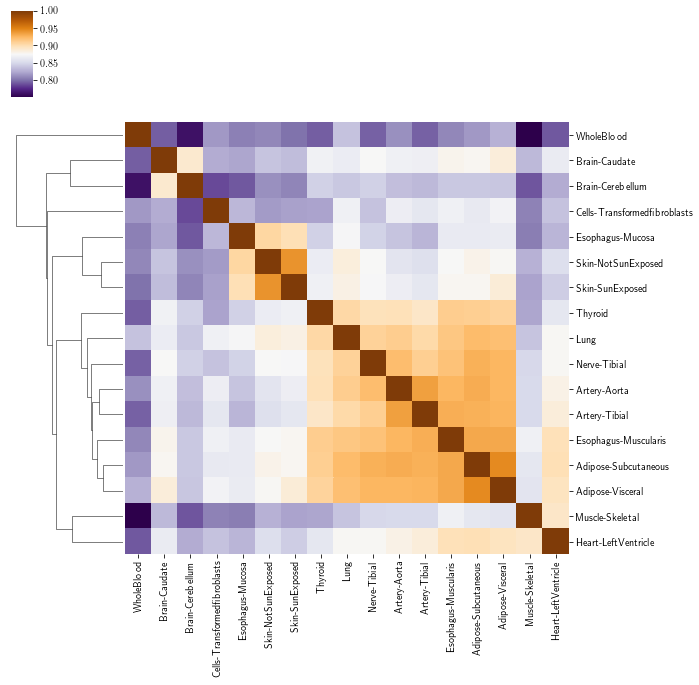

In [17]:
corrMatrix = pd.DataFrame(corrMatrix, columns=TISSUES, index=TISSUES)
cg = sns.clustermap(corrMatrix, cmap="PuOr_r")
cg.ax_col_dendrogram.set_visible(False)
if SAVEPLOT: cg.savefig(os.path.join(RESULTSDIR, "Figure1_mashRHeatmap.pdf"))

shared across 2 or more tissues: 0.8770764119601329
shared across 10 or more tissues: 0.49169435215946844


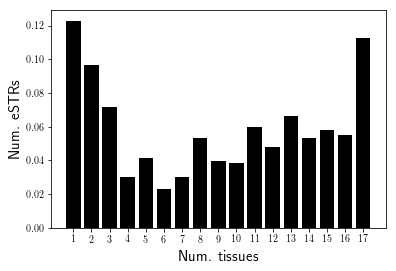

In [20]:
# Tissue sharing
ZTHRESH = 4 # TODO is this a good threshold? check mashr paper
numshared = zscores_estrs.apply(lambda x: sum(abs(x)>=ZTHRESH), 1) # takes a long time to run

# Tissue sharing
zscores_sig = zscores_estrs.copy()
zscores_sig["num"] = numshared
zscores_sig = zscores_sig[zscores_sig["num"]>0]
signum = zscores_sig.groupby("num", as_index=False).agg({"WholeBlood":len})
signum.columns = ["num.tissues", "num.estrs"]
signum["perc.estrs"] = signum["num.estrs"]/sum(signum["num.estrs"])
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(signum["num.tissues"], signum["perc.estrs"], color="black");
ax.set_xticks(range(1, ntissues+1));
ax.set_xlabel("Num. tissues", size=15)
ax.set_ylabel("Num. eSTRs", size=15);
    
print("shared across 2 or more tissues: %s"%(sum(signum[signum["num.tissues"]>=2]["perc.estrs"])))
print("shared across 10 or more tissues: %s"%(sum(signum[signum["num.tissues"]>=10]["perc.estrs"])))
if SAVEPLOT: fig.savefig(os.path.join(RESULTSDIR, "SuppFig_TissueSharing.pdf"))

# Tissue specificity

In [9]:
# Build a table of for each tissue:
# eSTR, num tissues where analyzed (linreg), num. tissue where significant (mashR), num. tissues where significant (linreg)

tspec = causal[["chrom","str.start","gene"]].copy()
tspec["ID"] = tspec.apply(lambda x: "%s_%s_%s"%(x["chrom"],x["str.start"], x["gene"]), 1)
tspec["num.analyzed"] = 0
tspec["num.sig.linreg"] = 0

for t in TISSUES:
    print(t)
    d = master[t]
    d = d[~np.isnan(d["linreg.pval"])]
    dids = (d.apply(lambda x: "%s_%s_%s"%(x["chrom"],x["str.start"], x["gene"]), 1))
    didssig = (dids[d["linreg.significant"]])
    dids = set(dids)
    didssig = set(didssig)
    
    tspec.loc[tspec["ID"].apply(lambda x: x in dids), "num.analyzed"] += 1
    tspec.loc[tspec["ID"].apply(lambda x: x in didssig), "num.sig.linreg"] += 1


Esophagus-Muscularis
Adipose-Visceral
Artery-Aorta
Muscle-Skeletal
Skin-SunExposed
Lung
Brain-Cerebellum
Artery-Tibial
Skin-NotSunExposed
Heart-LeftVentricle
Brain-Caudate
Thyroid
Nerve-Tibial
Adipose-Subcutaneous
WholeBlood
Cells-Transformedfibroblasts
Esophagus-Mucosa


In [96]:
tspec["num.sig.mashr"] = list(zscores_estrs.apply(lambda x: sum(abs(x)>=3), 1))

# Motif enrichment - overall

In [11]:
# All ref data
allstrs = pd.read_csv(os.path.join(DATADIR, "misc", "all_analyzed_strs.tab"), sep="\t")
ref = pd.read_csv(os.path.join(DATADIR, "misc", "annotations", "hg19.hipstr_reference_annot.bed"), sep="\t")
ref["str.start"]=ref["start"]
ref = pd.merge(ref, allstrs[["chrom","str.start"]].drop_duplicates(), on=["chrom","str.start"])

/usr/lib/python3.4/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
/usr/lib/python3.4/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in double_scalars


,annot,dir.causal,dir.estrs,num.causal,num.estrs,num.total,odds.causal,odds.estrs,p.dir.causal,p.dir.estrs,pval.causal,pval.estrs
92,CCCCGG,0.666667,0.583333,6,12,20,11.187099,6.957684,0.687500,0.774414,6.271938e-05,2.944817e-05
94,CCCGG,1.000000,0.571429,3,7,12,8.695747,6.492556,0.250000,1.000000,8.623692e-03,1.894880e-03
93,CCCG,0.500000,0.666667,4,9,17,8.028326,5.217553,1.000000,0.507812,3.006502e-03,1.063418e-03
74,AGCCCC,0.500000,0.545455,6,11,29,6.809026,2.834206,1.000000,1.000000,5.777860e-04,1.159925e-02
91,CCCCG,0.714286,0.529412,7,17,35,6.526468,4.381330,0.453125,1.000000,2.524459e-04,2.911796e-05
73,AGCCC,0.750000,0.625000,4,8,23,5.492790,2.473225,0.625000,0.726563,9.379967e-03,4.982537e-02
90,CCCCCG,0.500000,0.600000,4,10,23,5.492790,3.567545,1.000000,0.753906,9.379967e-03,3.686123e-03
67,AGAGGC,0.666667,0.285714,3,7,19,4.891071,2.705046,1.000000,0.453125,3.135260e-02,6.273049e-02
11,AAACT,0.333333,0.500000,3,6,19,4.891071,2.140138,1.000000,1.000000,3.135260e-02,1.295335e-01
95,CCG,0.642857,0.597015,28,67,195,4.392079,2.431161,0.184933,0.142071,9.963778e-10,2.734228e-08


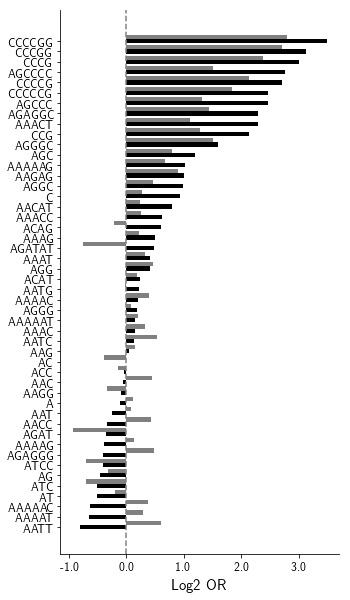

In [67]:
motifs = ref.groupby("motif", as_index=False).agg({"str.start": len})
motifs = motifs[motifs["motif"] != "ACACAC"]
motifs = list(motifs[motifs["str.start"]>=10]["motif"])
ref_motif = ref[["chrom","str.start","motif"]].copy()
ref_motif["annot"] = ref_motif["motif"]
motif_enrich_all = GetEnrichments(ref_motif, estrs, causal, motifs, annot_col=True)
motif_enrich_all = motif_enrich_all[motif_enrich_all["num.causal"]>=3]

fname = None
PlotEnrich(motif_enrich_all.sort_values("odds.causal", ascending=True), size=(5, 10), fname=fname)

motif_enrich_all = motif_enrich_all.sort_values("odds.causal", ascending=False)
motif_enrich_all

# Motifs - by clusters

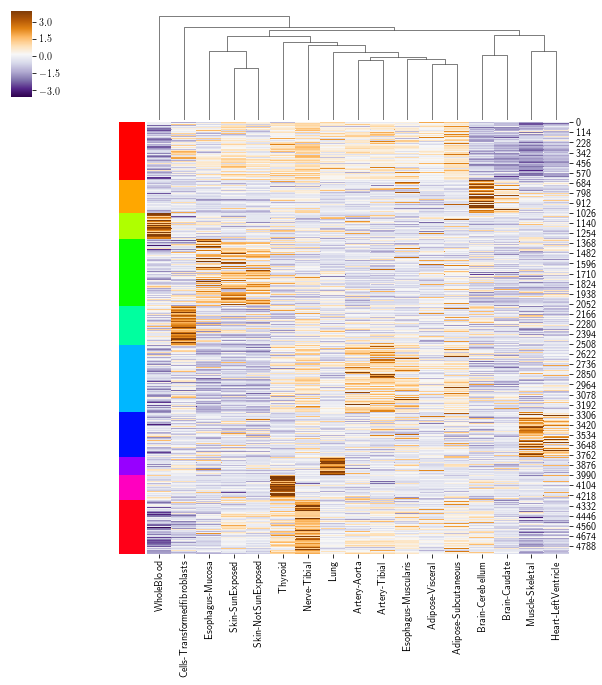

In [113]:
# Cluster eSTRs by tissue sharing pattern
from sklearn.cluster import KMeans
K = 10
estrs_clust = abs(betas_estrs.copy())
# Z-norm each row
means = estrs_clust.apply(np.mean, 1)
sds = estrs_clust.apply(lambda x: np.sqrt(np.var(x)), 1)
for t in TISSUES:
    estrs_clust[t] = (estrs_clust[t]-means)/sds
kmeans = KMeans(n_clusters=K, random_state=0).fit(estrs_clust)
estrs_clust["KClust"] = kmeans.labels_
estrs_clust = estrs_clust.sort_values("KClust")
estrs_clust["chrom"] = [x.split("_")[1] for x in estrs_clust.index]
estrs_clust["str.start"] = [int(x.split("_")[2]) for x in estrs_clust.index]
estrs_clust.index = range(estrs_clust.shape[0]) # else latex breaks in figure

# Plot zscores
def get_cmap(n, name='hsv'):
    return plt.cm.get_cmap(name, n)

def GetColor(val):
    cmap = get_cmap(K)
    return cmap(val)

cluster_colors = [GetColor(val) for val in estrs_clust["KClust"]]
cg = sns.clustermap(estrs_clust[TISSUES], cmap="PuOr_r", row_cluster=False, row_colors = cluster_colors)
cg.ax_row_dendrogram.set_visible(False)

In [103]:
# Motif enrichment for each cluster
motif_enrich_results = []
ref_motif_estrs = pd.merge(ref_motif, estrs[["chrom","str.start"]], on=["chrom","str.start"])

for clustid in range(K):
    eclust = pd.merge(causal, estrs_clust[estrs_clust["KClust"]==clustid][["chrom","str.start"]], on=["chrom","str.start"])
    motif_enrich = GetEnrichments(ref_motif_estrs, estrs, eclust, motifs, annot_col=True)
    motif_enrich_results.append(motif_enrich)
    

/usr/lib/python3.4/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in double_scalars
/usr/lib/python3.4/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars


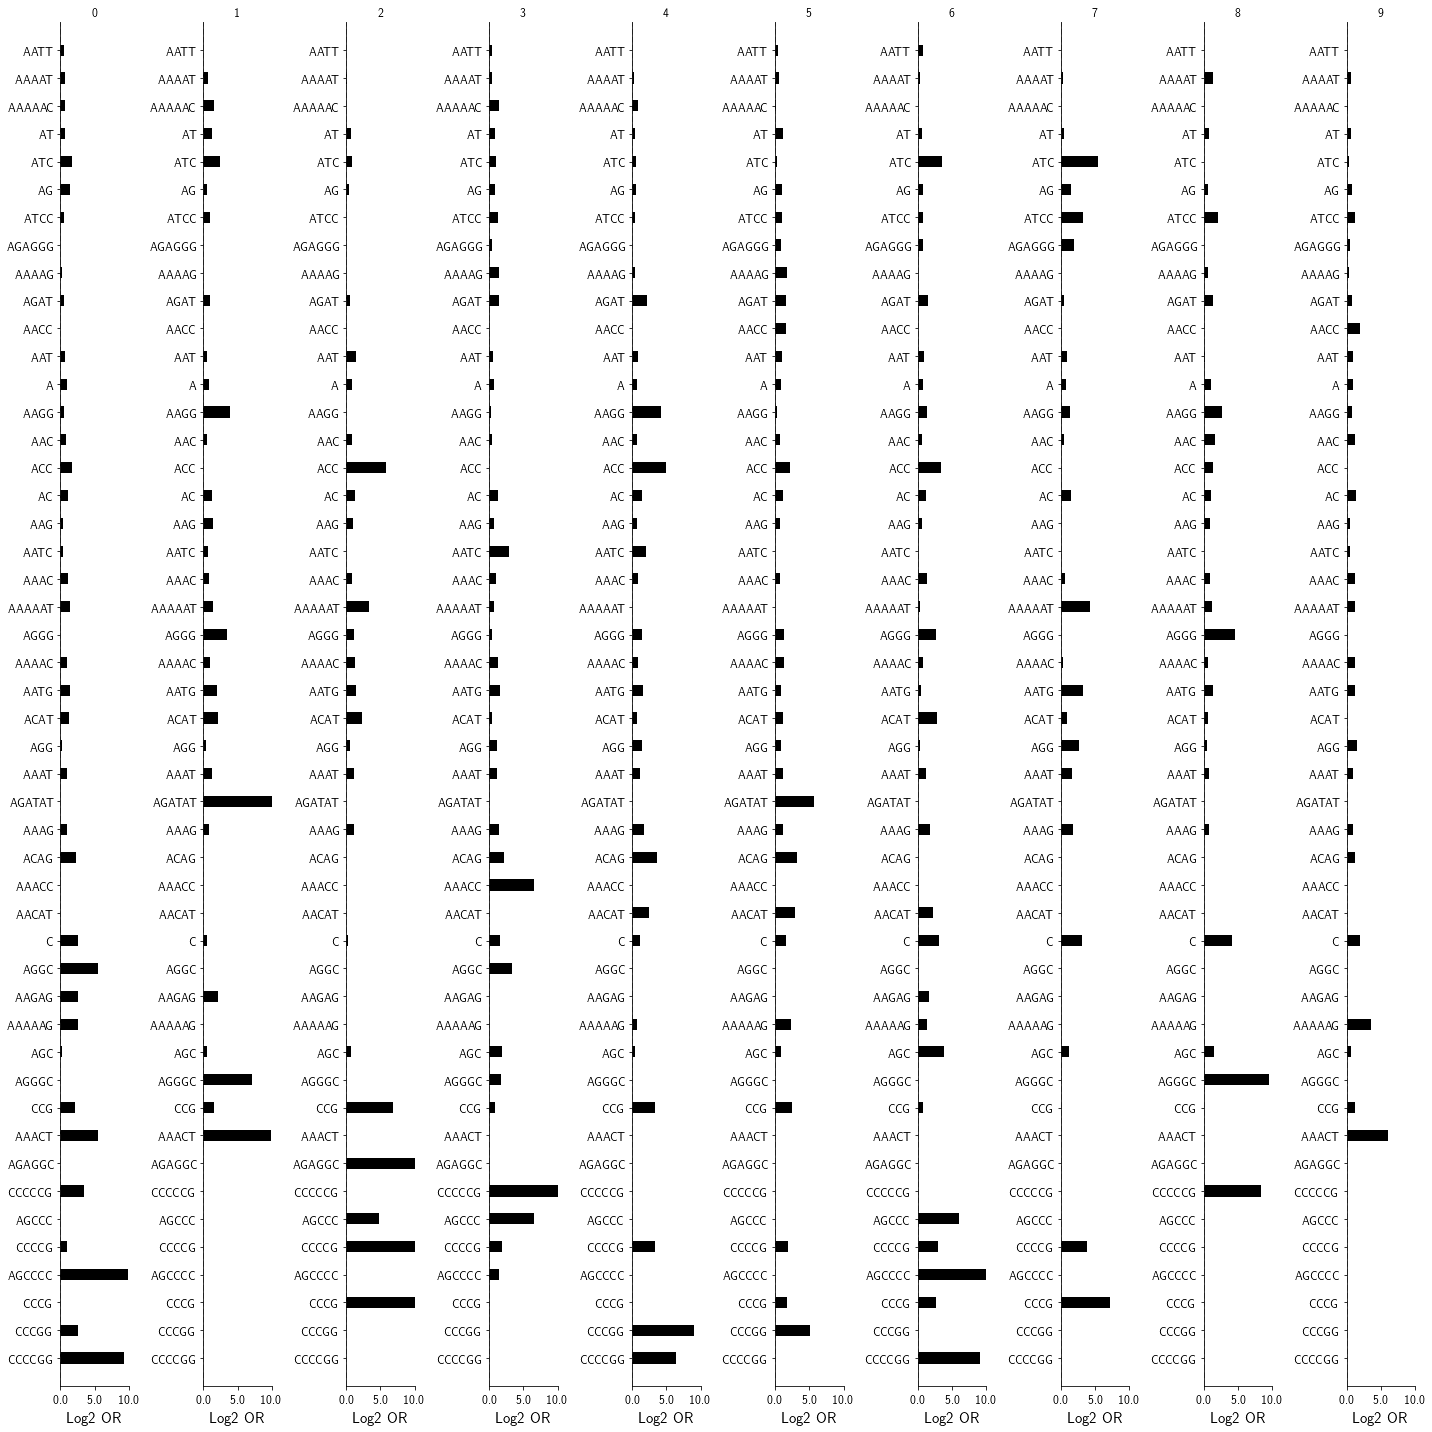

In [104]:
fig = plt.figure()
fig.set_size_inches((20, 20))
for clustid in range(K):
    ax = fig.add_subplot(1, K, clustid+1)
    # Get in same order as the overall
    d = motif_enrich_results[clustid]
    d = pd.merge(d, motif_enrich_all[["odds.causal","annot"]], on=["annot"]).sort_values("odds.causal_y", ascending=False)
    d["odds.causal"] = d["odds.causal_x"]
    # Plot
    PlotEnrich(d, size=(3, 10), fname=None, title=clustid, ax=ax, log2=False)
    ax.set_xlim(left=0, right=10)
    ax.set_xticklabels(ax.get_xticks())
    ax.set_ylim(bottom=-1, top=d.shape[0])
fig.tight_layout()


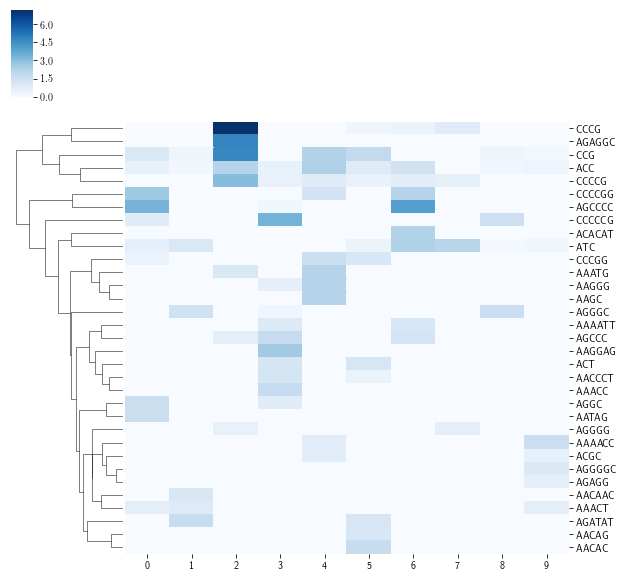

In [105]:
motif_ORs = []
motif_pvals = []
allmotifs = []
for motif in set(ref_motif["motif"]):
    ors = []
    pvals = []
    for k in range(K):
        d = motif_enrich_results[k]
        try:
            val = d[d["annot"]==motif]["odds.causal"].values[0]
            ors.append(val)
            pval = d[d["annot"]==motif]["pval.causal"].values[0]
            pvals.append(pval)
        except:
            ors.append(0)
            pvals.append(1)
    if len(ors) == 0: continue
    if max(ors)>=5:
        motif_ORs.append(ors)
        allmotifs.append(motif)
        motif_pvals.append(pvals)
motif_ORs = pd.DataFrame(motif_ORs, columns=range(K), index=allmotifs)
motif_ORs = motif_ORs.drop("AGAGAG")
motif_ORs = motif_ORs.drop("AGAG")

motif_pvals = -1*np.log10(pd.DataFrame(motif_pvals, columns=range(K), index=allmotifs))
motif_pvals = motif_pvals.drop("AGAGAG")
motif_pvals = motif_pvals.drop("AGAG")

sns.clustermap(motif_pvals, cmap="Blues", col_cluster=False)

In [18]:
motif_ORs.to_csv("cluster_motif_enrichment.csv")

In [52]:
clustid=7
eclust = pd.merge(causal, estrs_clust[estrs_clust["KClust"]==clustid][["chrom","str.start"]], on=["chrom","str.start"])
#eclust[eclust["motif"]=="AAATG"]
m = "AGAGGC"
eclust[(eclust["str.motif.forward"]==m) | (eclust["str.motif.reverse"]==m)]

,chrom,str.start,gene,gene.name,num.e,beta,pval,score,tissue_info,str.end,str.motif.forward,str.motif.reverse
38,chr10,72994833,ENSG00000107731,UNC5B,2,-0.455022,2.015890e-18,0.108259,WholeBlood_-0.46_0.11;Esophagus-Mucosa_-0.21_0.01,72994877,CCTCTG,AGAGGC
56,chr11,45777182,ENSG00000121671,CRY2,1,0.196567,3.346467e-04,0.118223,WholeBlood_0.20_0.12,45777220,AGAGGC,CCTCTG
233,chr22,38201266,ENSG00000189060,H1F0,1,0.335488,4.822556e-10,0.904027,WholeBlood_0.34_0.90,38201298,AGAGGC,CCTCTG


In [95]:
tspec

,chrom,str.start,gene,ID,num.analyzed,num.sig.linreg,num.sig.mashr
2,chr1,886040,ENSG00000188976,chr1_886040_ENSG00000188976,14,5,11
4,chr1,930889,ENSG00000188290,chr1_930889_ENSG00000188290,17,2,0
11,chr1,952495,ENSG00000188157,chr1_952495_ENSG00000188157,17,6,5
21,chr1,1323946,ENSG00000131584,chr1_1323946_ENSG00000131584,17,3,8
22,chr1,1323946,ENSG00000160072,chr1_1323946_ENSG00000160072,17,8,11
32,chr1,1437601,ENSG00000160072,chr1_1437601_ENSG00000160072,16,4,13
33,chr1,1437601,ENSG00000215915,chr1_1437601_ENSG00000215915,16,2,0
47,chr1,1694199,ENSG00000008128,chr1_1694199_ENSG00000008128,17,5,13
48,chr1,1694199,ENSG00000215790,chr1_1694199_ENSG00000215790,17,1,0
50,chr1,1711092,ENSG00000008130,chr1_1711092_ENSG00000008130,17,1,0


0.268931195914483
0.5230143529872632
0.1890116541424792
0.2932351489422828
0.17679121334939835
0.3132481519363321
0.21474633292326428
0.15279937090398565


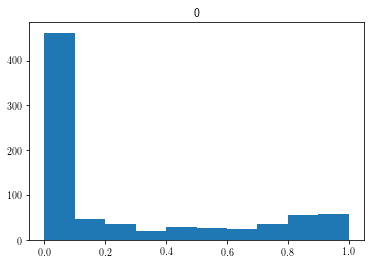

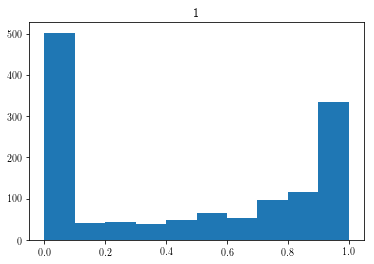

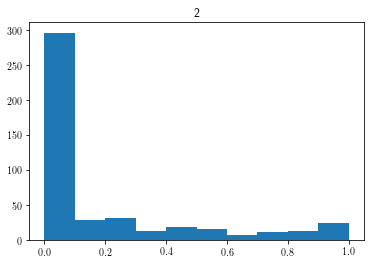

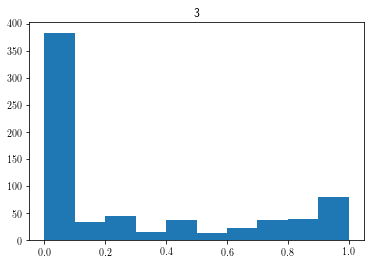

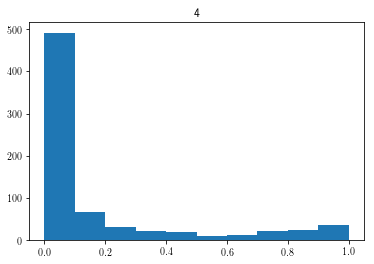

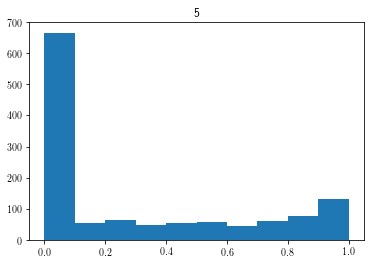

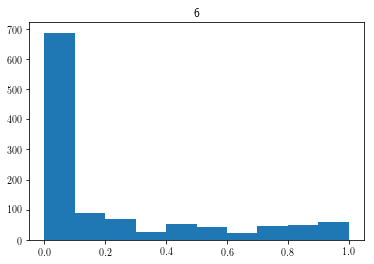

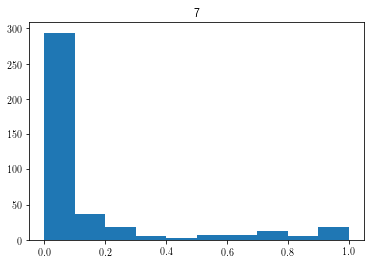

In [100]:
# Tissue specificity of each cluster
for clustid in range(K):
    eclust = pd.merge(causal, estrs_clust[estrs_clust["KClust"]==clustid][["chrom","str.start"]], on=["chrom","str.start"])
    d = pd.merge(eclust, tspec, on=["chrom","str.start"])
    vals = list(d["num.sig.mashr"]*1.0/d["num.analyzed"])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.hist(vals, bins=np.arange(0, 1.1, 0.1))
    ax.set_title(clustid)
    print(np.mean(vals))
#sns.violinplot(data=data)


# scratch below 

In [20]:
numshared = zscores.apply(lambda x: sum(abs(x)>=ZTHRESH), 1) # takes a long time to run

shared across 2 or more tissues: 0.8246019132155816
shared across 10 or more tissues: 0.3764656490838756


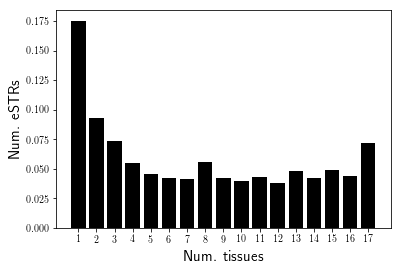

In [21]:
# Tissue sharing
zscores_sig = zscores.copy()
zscores_sig["num"] = numshared
zscores_sig = zscores_sig[zscores_sig["num"]>0]
signum = zscores_sig.groupby("num", as_index=False).agg({"WholeBlood":len})
signum.columns = ["num.tissues", "num.estrs"]
signum["perc.estrs"] = signum["num.estrs"]/sum(signum["num.estrs"])
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(signum["num.tissues"], signum["perc.estrs"], color="black");
ax.set_xticks(range(1, ntissues+1));
ax.set_xlabel("Num. tissues", size=15)
ax.set_ylabel("Num. eSTRs", size=15);

if SAVEPLOT: fig.savefig(os.path.join(RESULTSDIR, "SuppFig_TissueSharing.pdf"));
    
print("shared across 2 or more tissues: %s"%(sum(signum[signum["num.tissues"]>=2]["perc.estrs"])))
print("shared across 10 or more tissues: %s"%(sum(signum[signum["num.tissues"]>=10]["perc.estrs"])))

In [22]:
# Pairwise sharing
# Of effects sig in at least one, how many shared within factor of 2
shareMatrix = np.full((ntissues, ntissues), np.nan)
# Correlation of effect sizes
corrMatrix = np.full((ntissues, ntissues), np.nan)

for tissue1 in TISSUES:
    for tissue2 in TISSUES:
        t1ind = TISSUES.index(tissue1)
        t2ind = TISSUES.index(tissue2)
        significant = (zscores[tissue1] >=ZTHRESH) | (zscores[tissue2] >=ZTHRESH)
        sharedEffects = abs(np.log2(betas[tissue1]/betas[tissue2])) < 1
        shareMatrix[t1ind, t2ind] = np.sum(sharedEffects & significant)/np.sum(significant)
        shareMatrix[t2ind, t1ind] = shareMatrix[t1ind, t2ind]
        eff1 = betas[significant][tissue1]
        eff2 = betas[significant][tissue2]
        corrMatrix[t1ind, t2ind] = scipy.stats.spearmanr(eff1, eff2)[0]
        corrMatrix[t2ind, t1ind] = corrMatrix[t1ind, t2ind]

/usr/lib/python3.4/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log2
  if sys.path[0] == '':


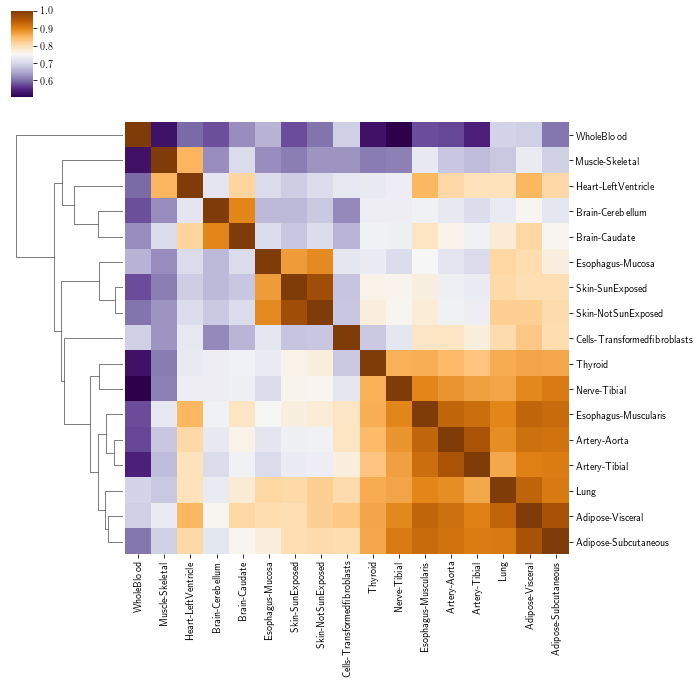

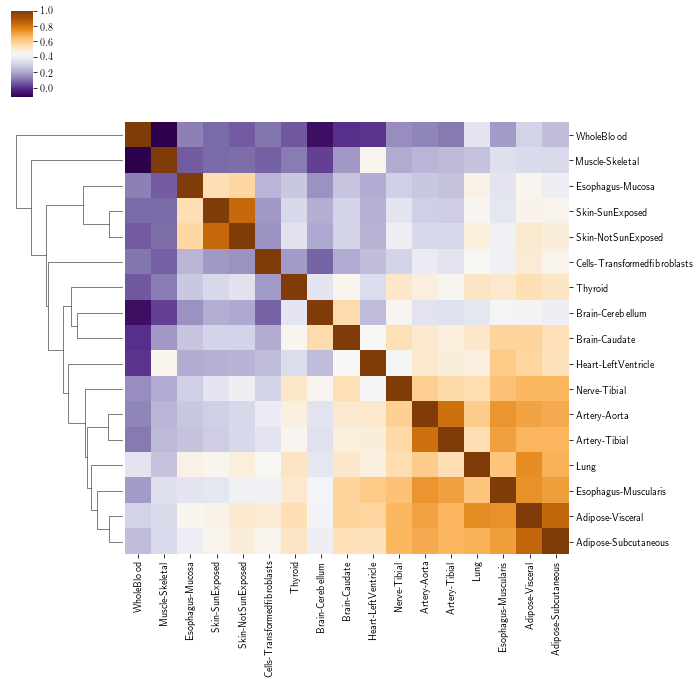

In [23]:
import seaborn as sns
shareMatrix = pd.DataFrame(shareMatrix, columns=TISSUES, index=TISSUES)
cg = sns.clustermap(shareMatrix, cmap="PuOr_r")
cg.ax_col_dendrogram.set_visible(False)
if SAVEPLOT: cg.savefig(os.path.join(RESULTSDIR, "Figure1_mashRHeatmap.pdf"));

corrMatrix = pd.DataFrame(corrMatrix, columns=TISSUES, index=TISSUES)
cg = sns.clustermap(corrMatrix, cmap="PuOr_r")
cg.ax_col_dendrogram.set_visible(False)
if SAVEPLOT: cg.savefig(os.path.join(RESULTSDIR, "SuppFig_mashRHeatmap_spearman.pdf"));

In [24]:
# Try clustering z-scores
def absmax(vals):
    return max([abs(item) for item in vals])
zmax = zscores.apply(absmax, 1)
sigestrs = zscores[zmax>=5] # TODO change to caviar definition
sigestrs.index = range(sigestrs.shape[0])


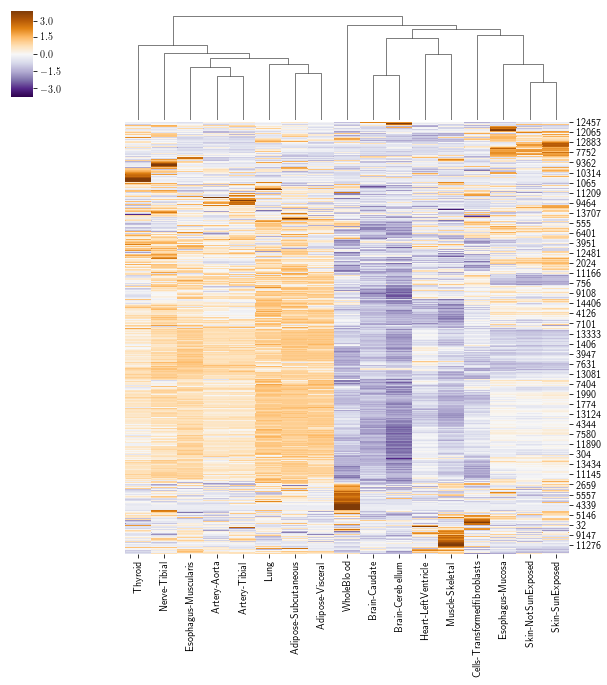

In [26]:
import seaborn as sns
cg = sns.clustermap(abs(sigestrs), z_score=0,cmap="PuOr_r");
cg.ax_row_dendrogram.set_visible(False)